In [1]:
import os, re, glob, warnings
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

import torch
from transformers import AutoTokenizer, AutoModel

import yfinance as yf

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score, classification_report
)
from xgboost import XGBRegressor, XGBClassifier

# ── CONFIG ─────────────────────────────────────────────────────────────────
MAEC_ROOT      = 'C:\\applied time series\\ats sem project\\ats data\\MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master'   # 📂 Change this to your dataset path
OUTPUT_DIR     = 'C:\\applied time series\\ats sem project\\outputs'   # 📂 Change this to your desired output path
DEVICE         = 'cuda' if torch.cuda.is_available() else 'cpu'
TRAIN_END_YEAR = 2018   # time-based split
TEST_START_YEAR= 2019

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'Device: {DEVICE}')
print(f'MAEC root: {MAEC_ROOT}')
print('✅ Imports complete')

Device: cuda
MAEC root: C:\applied time series\ats sem project\ats data\MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction-master
✅ Imports complete


In [2]:
import os

MAEC_ROOT = os.path.join(MAEC_ROOT, 'MAEC_Dataset')

# Verify
folders = [d for d in os.listdir(MAEC_ROOT) if os.path.isdir(os.path.join(MAEC_ROOT, d))]
print(f"✅ Fixed! Found {len(folders)} folders")
print(f"Sample: {folders[:5]}")

✅ Fixed! Found 3443 folders
Sample: ['20150225_LMAT', '20150226_ACIW', '20150226_ADSK', '20150226_AMWD', '20150226_ANSS']


In [3]:
# ── CELL 4 (FIXED) — Full Build ────────────────────────────────────────────

def parse_folder_name(folder_name):
    """
    Handles formats like:
      20150302_MU
      20150302_TG_NX
      2015-03-02_MU   (just in case)
    Returns (date as dd/mm/yyyy string, ticker)
    """
    # Normalize: remove dashes from date part if present
    folder_name = folder_name.strip()
    parts = folder_name.split('_')
    
    if len(parts) < 2:
        return None, None
    
    raw_date = parts[0].replace('-', '')  # handle 2015-03-02 or 20150302
    ticker   = parts[-1].upper()          # last segment = ticker
    
    # Validate date is 8 digits
    if not raw_date.isdigit() or len(raw_date) != 8:
        return None, None
    
    try:
        # raw_date is YYYYMMDD → parse and reformat to dd/mm/yyyy
        dt   = datetime.strptime(raw_date, '%Y%m%d')
        date = dt.strftime('%d/%m/%Y')
    except ValueError:
        return None, None
    
    return date, ticker


def read_transcript(folder_path):
    """
    Reads the first .txt file found in the folder.
    Tries common names first, then falls back to any .txt.
    """
    candidates = ['text.txt', 'transcript.txt', 'call.txt', 'body.txt', 'content.txt']
    for c in candidates:
        fp = os.path.join(folder_path, c)
        if os.path.exists(fp):
            with open(fp, 'r', encoding='utf-8', errors='ignore') as f:
                return f.read().strip()
    
    # Fallback: grab any .txt file
    txt_files = glob.glob(os.path.join(folder_path, '*.txt'))
    if txt_files:
        with open(txt_files[0], 'r', encoding='utf-8', errors='ignore') as f:
            return f.read().strip()
    
    return None


# ── Main loop ──────────────────────────────────────────────────────────────
records       = []
skipped_parse = []
skipped_txt   = []

folders = sorted([
    d for d in os.listdir(MAEC_ROOT)
    if os.path.isdir(os.path.join(MAEC_ROOT, d))
])

print(f"Found {len(folders)} folders. Parsing...")

for folder in tqdm(folders, desc='Parsing folders'):
    date, ticker = parse_folder_name(folder)
    
    if date is None:
        skipped_parse.append(folder)
        continue
    
    transcript = read_transcript(os.path.join(MAEC_ROOT, folder))
    
    if transcript is None or len(transcript) < 50:
        skipped_txt.append(folder)
        continue
    
    records.append({
        'folder'    : folder,
        'ticker'    : ticker,
        'date'      : date,
        'transcript': transcript
    })

# ── Report ─────────────────────────────────────────────────────────────────
print(f"\n✅ Parsed successfully : {len(records)}")
print(f"❌ Skipped (bad name)  : {len(skipped_parse)}  e.g. {skipped_parse[:3]}")
print(f"❌ Skipped (no .txt)   : {len(skipped_txt)}   e.g. {skipped_txt[:3]}")

if len(records) == 0:
    print("\n⚠️  records is EMPTY. Check the two skip lists above.")
    print("Most likely cause: .txt file has a different name inside the folder.")
    print("Run this to inspect one folder:")
    print(f"  print(os.listdir(os.path.join(MAEC_ROOT, folders[0])))")
else:
    df_raw = pd.DataFrame(records)
    # date is already dd/mm/yyyy string — convert to datetime
    df_raw['date'] = pd.to_datetime(df_raw['date'], format='%d/%m/%Y')
    df_raw.to_csv(f'{OUTPUT_DIR}/events_raw.csv', index=False)

    print(f'\n✅ events_raw.csv  →  {len(df_raw)} events')
    print(df_raw[['ticker', 'date', 'folder']].head(10))
    print(f"\nDate range : {df_raw['date'].min().date()} → {df_raw['date'].max().date()}")
    print(f"Unique tickers: {df_raw['ticker'].nunique()}")

Found 3443 folders. Parsing...


Parsing folders: 100%|██████████| 3443/3443 [00:01<00:00, 1871.70it/s]



✅ Parsed successfully : 3419
❌ Skipped (bad name)  : 0  e.g. []
❌ Skipped (no .txt)   : 24   e.g. ['20150504_TXRH', '20150506_NSIT', '20150508_WELL']

✅ events_raw.csv  →  3419 events
  ticker       date         folder
0   LMAT 2015-02-25  20150225_LMAT
1   ACIW 2015-02-26  20150226_ACIW
2   ADSK 2015-02-26  20150226_ADSK
3   AMWD 2015-02-26  20150226_AMWD
4   ANSS 2015-02-26  20150226_ANSS
5    CRI 2015-02-26   20150226_CRI
6   ECPG 2015-02-26  20150226_ECPG
7    GPS 2015-02-26   20150226_GPS
8   IRDM 2015-02-26  20150226_IRDM
9    JCP 2015-02-26   20150226_JCP

Date range : 2015-02-25 → 2018-06-21
Unique tickers: 1209


In [4]:
# ── Load raw events (skip if running from scratch) ─────────────────────────
if 'df_raw' not in dir():
    df_raw = pd.read_csv(f'{OUTPUT_DIR}/events_raw.csv', parse_dates=['date'])

# ── Helper functions ───────────────────────────────────────────────────────

def get_prices(ticker, date, window=10):
    """
    Download adjusted close + volume around event date.
    Returns DataFrame with columns: adj_close, volume.
    """
    start = (date - timedelta(days=window*3)).strftime('%Y-%m-%d')
    end   = (date + timedelta(days=window*3)).strftime('%Y-%m-%d')
    try:
        data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        if data.empty:
            return None
        data.index = pd.to_datetime(data.index)
        return data[['Close', 'Volume']].rename(columns={'Close':'adj_close','Volume':'volume'})
    except Exception:
        return None


def get_market(date, window=10):
    start = (date - timedelta(days=window*3)).strftime('%Y-%m-%d')
    end   = (date + timedelta(days=window*3)).strftime('%Y-%m-%d')
    try:
        data = yf.download('^GSPC', start=start, end=end, progress=False, auto_adjust=True)
        if data.empty:
            return None
        data.index = pd.to_datetime(data.index)
        return data[['Close']].rename(columns={'Close':'market_close'})
    except Exception:
        return None


def compute_car(ticker_prices, market_prices, event_date):
    features = {}

    # ── Flatten MultiIndex columns if yfinance returns them ───────────────
    def flatten_df(df):
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]
        return df

    ticker_prices = flatten_df(ticker_prices.copy())
    market_prices = flatten_df(market_prices.copy())

    # ── Ensure index is plain DatetimeIndex (drop ticker level if present) ─
    ticker_prices.index = pd.to_datetime(ticker_prices.index.get_level_values(0))
    market_prices.index = pd.to_datetime(market_prices.index.get_level_values(0))

    # ── Remove duplicate dates (keep last) ────────────────────────────────
    ticker_prices = ticker_prices[~ticker_prices.index.duplicated(keep='last')]
    market_prices = market_prices[~market_prices.index.duplicated(keep='last')]

    # ── Merge on date ──────────────────────────────────────────────────────
    df = ticker_prices.join(market_prices, how='inner')
    if len(df) < 5:
        return None

    # Log returns
    df['r_stock']  = np.log(df['adj_close'] / df['adj_close'].shift(1))
    df['r_market'] = np.log(df['market_close'] / df['market_close'].shift(1))
    df = df.dropna()

    if len(df) < 5:
        return None

    # Find event date (or next available trading day)
    trading_days = df.index.sort_values()
    future_days  = trading_days[trading_days >= pd.Timestamp(event_date)]
    if len(future_days) == 0:
        return None
    t0  = future_days[0]
    idx = trading_days.get_loc(t0)  # guaranteed integer now (no duplicates)

    # Estimation window: [-35, -5] for beta
    est_start  = max(0, idx - 35)
    est_end    = max(0, idx - 5)
    est_window = df.iloc[est_start:est_end]

    if len(est_window) < 10:
        beta, alpha = 1.0, 0.0
    else:
        from sklearn.linear_model import LinearRegression as LR
        X  = est_window['r_market'].values.reshape(-1, 1)
        y  = est_window['r_stock'].values
        lr = LR().fit(X, y)
        beta  = float(lr.coef_[0])
        alpha = float(lr.intercept_)

    # Abnormal return at a given position
    def get_ar(day_idx):
        if day_idx < 0 or day_idx >= len(df):
            return np.nan
        r_s = float(df['r_stock'].iloc[day_idx])
        r_m = float(df['r_market'].iloc[day_idx])
        return r_s - (alpha + beta * r_m)

    ar0 = get_ar(idx)
    ar1 = get_ar(idx + 1)

    # Both must be valid scalars
    if np.isnan(ar0) or np.isnan(ar1):
        return None

    features['CAR'] = ar0 + ar1
    features['AR0'] = ar0
    features['AR1'] = ar1

    # Returns r[-5 .. +5]
    for offset in range(-5, 6):
        features[f'r_{offset:+d}'] = get_ar(idx + offset)

    # Pre-event volatility
    features['pre_volatility'] = float(est_window['r_stock'].std()) if len(est_window) > 2 else np.nan

    # Volume ratio
    pre_vol_window = df.iloc[max(0, idx - 5):idx]['volume']
    event_vol      = float(df['volume'].iloc[idx]) if idx < len(df) else np.nan
    avg_pre_vol    = float(pre_vol_window.mean()) if len(pre_vol_window) > 0 else np.nan
    features['volume_ratio'] = event_vol / avg_pre_vol if (avg_pre_vol and avg_pre_vol > 0) else np.nan

    # Market return on event day
    features['market_r0'] = float(df['r_market'].iloc[idx]) if idx < len(df) else np.nan

    # Momentum [-20, -2]
    mom_start = max(0, idx - 20)
    mom_end   = max(0, idx - 1)
    features['momentum_20d'] = float(df.iloc[mom_start:mom_end]['r_stock'].sum())

    return features


# ── Main loop ──────────────────────────────────────────────────────────────
# Cache market data per date to avoid repeated downloads
market_cache = {}

fin_rows = []
failed   = 0

for _, row in tqdm(df_raw.iterrows(), total=len(df_raw), desc='Computing CAR'):
    ticker     = row['ticker']
    event_date = row['date']
    date_key   = event_date.strftime('%Y-%m')

    # Ticker prices
    prices = get_prices(ticker, event_date)
    if prices is None:
        failed += 1
        continue

    # Market prices (cache by month)
    if date_key not in market_cache:
        market_cache[date_key] = get_market(event_date)
    market = market_cache[date_key]
    if market is None:
        failed += 1
        continue

    car_features = compute_car(prices, market, event_date)
    if car_features is None:
        failed += 1
        continue

    combined = {
        'folder'    : row['folder'],
        'ticker'    : ticker,
        'date'      : event_date,
        'transcript': row['transcript'],
        **car_features
    }
    fin_rows.append(combined)


df_finance = pd.DataFrame(fin_rows)
df_finance.to_csv(f'{OUTPUT_DIR}/events_with_finance.csv', index=False)

print(f'\n✅ events_with_finance.csv  →  {len(df_finance)} events  ({failed} failed/skipped)')
print(f"CAR stats:\n{df_finance['CAR'].describe()}")
print(f"\nColumns: {list(df_finance.columns)}")

Computing CAR:   0%|          | 4/3419 [00:01<19:36,  2.90it/s]HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ANSS"}}}
$ANSS: possibly delisted; no timezone found

1 Failed download:
['ANSS']: possibly delisted; no timezone found
Computing CAR:   0%|          | 7/3419 [00:03<25:09,  2.26it/s]$GPS: possibly delisted; no timezone found

1 Failed download:
['GPS']: possibly delisted; no timezone found
Computing CAR:   0%|          | 9/3419 [00:04<27:42,  2.05it/s]$JCP: possibly delisted; no timezone found

1 Failed download:
['JCP']: possibly delisted; no timezone found
Computing CAR:   0%|          | 13/3419 [00:06<20:50,  2.72it/s]$RDC: possibly delisted; no timezone found

1 Failed download:
['RDC']: possibly delisted; no timezone found
Computing CAR:   0%|          | 14/3419 [00:06<23:25,  2.42it/s]$SJI: possibly delisted; no timezone found

1 Failed download:
['SJI']: possibly delisted; no timezone found
Computing


✅ events_with_finance.csv  →  2509 events  (910 failed/skipped)
CAR stats:
count    2509.000000
mean        0.001262
std         0.075080
min        -0.746725
25%        -0.035477
50%         0.002678
75%         0.038017
max         0.460675
Name: CAR, dtype: float64

Columns: ['folder', 'ticker', 'date', 'transcript', 'CAR', 'AR0', 'AR1', 'r_-5', 'r_-4', 'r_-3', 'r_-2', 'r_-1', 'r_+0', 'r_+1', 'r_+2', 'r_+3', 'r_+4', 'r_+5', 'pre_volatility', 'volume_ratio', 'market_r0', 'momentum_20d']


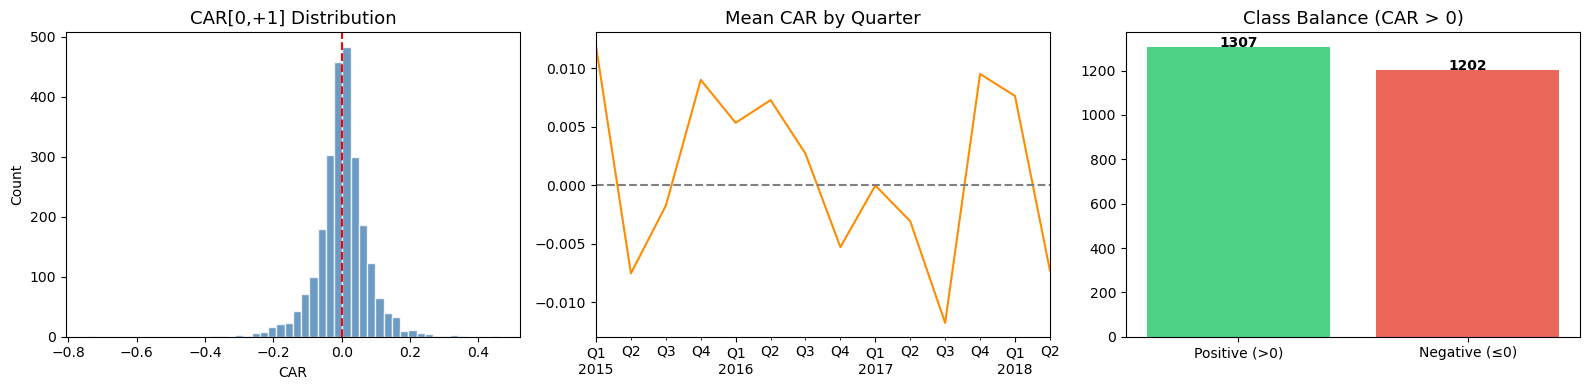

Positive CAR: 1307 (52.1%)


In [5]:
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f'{OUTPUT_DIR}/events_with_finance.csv', parse_dates=['date'])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# CAR histogram
axes[0].hist(df_finance['CAR'].dropna(), bins=50, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title('CAR[0,+1] Distribution', fontsize=13)
axes[0].set_xlabel('CAR')
axes[0].set_ylabel('Count')

# CAR over time
df_finance.set_index('date')['CAR'].resample('Q').mean().plot(ax=axes[1], color='darkorange')
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Mean CAR by Quarter', fontsize=13)
axes[1].set_xlabel('')

# Class balance
labels = ['Positive (>0)', 'Negative (≤0)']
counts = [(df_finance['CAR'] > 0).sum(), (df_finance['CAR'] <= 0).sum()]
axes[2].bar(labels, counts, color=['#2ecc71', '#e74c3c'], alpha=0.85)
axes[2].set_title('Class Balance (CAR > 0)', fontsize=13)
for i, v in enumerate(counts):
    axes[2].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/car_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Positive CAR: {counts[0]} ({counts[0]/sum(counts)*100:.1f}%)")

In [6]:
E5_MODEL="intfloat/e5-large-v2"
tokenizer=AutoTokenizer.from_pretrained(E5_MODEL)
model=AutoModel.from_pretrained(E5_MODEL).to(DEVICE)
model.eval()

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertModel LOAD REPORT from: intfloat/e5-large-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [8]:
def e5_embed(text,chunk=512,overlap=50):
    text="passage: "+text
    tokens=tokenizer(text,add_special_tokens=False,return_tensors='pt')
    ids=tokens['input_ids'][0]
    step=chunk-overlap
    embs=[]

    for i in range(0,len(ids),step):
        part=ids[i:i+chunk-2]
        part=torch.cat([torch.tensor([tokenizer.cls_token_id]),part,torch.tensor([tokenizer.sep_token_id])]).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out=model(part)
        embs.append(out.last_hidden_state.mean(dim=1).cpu().numpy()[0])
    return np.mean(embs,axis=0)

embeddings=[]
for t in tqdm(df_finance['transcript']):
    try: embeddings.append(e5_embed(t))
    except: embeddings.append(np.zeros(1024))

emb=np.array(embeddings)
np.save(f"{OUTPUT_DIR}/embeddings.npy",emb)
print("Embedding shape:",emb.shape)

100%|██████████| 2509/2509 [13:50<00:00,  3.02it/s]

Embedding shape: (2509, 1024)


In [11]:
if 'df_finance' not in dir():
    df_finance = pd.read_csv(f'{OUTPUT_DIR}/events_with_finance.csv', parse_dates=['date'])
if 'embeddings_array' not in dir():
    embeddings_array = np.load(f'{OUTPUT_DIR}/embeddings.npy')

# ── Embedding columns ──────────────────────────────────────────────────────
emb_cols  = [f'emb_{i}' for i in range(embeddings_array.shape[1])]
df_emb    = pd.DataFrame(embeddings_array, columns=emb_cols)

# ── Define financial feature columns ──────────────────────────────────────
FIN_FEATURES = [
    'r_-5', 'r_-4', 'r_-3', 'r_-2', 'r_-1', 'r_+0',
    'r_+1', 'r_+2', 'r_+3', 'r_+4', 'r_+5',
    'pre_volatility', 'volume_ratio', 'market_r0', 'momentum_20d'
]
FIN_FEATURES = [c for c in FIN_FEATURES if c in df_finance.columns]

# ── Merge ──────────────────────────────────────────────────────────────────
df_final = pd.concat(
    [
        df_finance[['ticker','date','CAR'] + FIN_FEATURES].reset_index(drop=True),
        df_emb
    ],
    axis=1
)

# ── Binary target ──────────────────────────────────────────────────────────
df_final['CAR_binary'] = (df_final['CAR'] > 0).astype(int)

# Drop rows with missing CAR
df_final = df_final.dropna(subset=['CAR'])
df_final.to_csv(f'{OUTPUT_DIR}/final_dataset.csv', index=False)

print(f'✅ final_dataset.csv  →  {len(df_final)} rows × {len(df_final.columns)} columns')
print(f'   Text features   : {len(emb_cols)}')
print(f'   Finance features: {len(FIN_FEATURES)}')
print(f'   Targets         : CAR (regression)  |  CAR_binary (classification)')

✅ final_dataset.csv  →  2509 rows × 1043 columns
   Text features   : 1024
   Finance features: 15
   Targets         : CAR (regression)  |  CAR_binary (classification)


In [12]:
# ── CELL 9 (FIXED) — Auto Time-Based Train/Test Split ─────────────────────

if 'df_final' not in dir():
    df_final = pd.read_csv(f'{OUTPUT_DIR}/final_dataset.csv', parse_dates=['date'])

# Year distribution
print("Year distribution:")
print(df_final['date'].dt.year.value_counts().sort_index())

# ── Auto split: 80% train, 20% test by time ───────────────────────────────
df_sorted   = df_final.sort_values('date').reset_index(drop=True)
split_idx   = int(len(df_sorted) * 0.80)
split_date  = df_sorted.iloc[split_idx]['date']

df_train = df_sorted.iloc[:split_idx].copy()
df_test  = df_sorted.iloc[split_idx:].copy()

print(f"\nAuto split date   : {split_date.date()}")
print(f"Train : {len(df_train)} events  ({df_train['date'].min().date()} → {df_train['date'].max().date()})")
print(f"Test  : {len(df_test)}  events  ({df_test['date'].min().date()} → {df_test['date'].max().date()})")

# Sanity check
assert len(df_test) > 0,  "❌ Test set is empty!"
assert len(df_train) > 0, "❌ Train set is empty!"

# ── Feature column definitions ─────────────────────────────────────────────
emb_cols = [c for c in df_final.columns if c.startswith('emb_')]

FIN_FEATURES = [
    'r_-5','r_-4','r_-3','r_-2','r_-1','r_+0',
    'r_+1','r_+2','r_+3','r_+4','r_+5',
    'pre_volatility','volume_ratio','market_r0','momentum_20d'
]
FIN_FEATURES = [c for c in FIN_FEATURES if c in df_final.columns]

TEXT_ONLY = emb_cols
FIN_ONLY  = FIN_FEATURES
FUSION    = emb_cols + FIN_FEATURES

print(f"\nFeature sets:")
print(f"  Text-only  : {len(TEXT_ONLY)}")
print(f"  Fin-only   : {len(FIN_ONLY)}")
print(f"  Fusion     : {len(FUSION)}")

# ── prepare_splits (also fixed to guard against empty sets) ───────────────
def prepare_splits(df_tr, df_te, feature_cols, target_col):
    # Drop any feature cols not present
    feature_cols = [c for c in feature_cols if c in df_tr.columns]
    
    X_tr = df_tr[feature_cols].fillna(0).values.astype(float)
    X_te = df_te[feature_cols].fillna(0).values.astype(float)
    y_tr = df_tr[target_col].values.astype(float)
    y_te = df_te[target_col].values.astype(float)

    assert X_tr.shape[0] > 0, "Train set is empty"
    assert X_te.shape[0] > 0, f"Test set is empty for features: {feature_cols[:3]}..."

    scaler = StandardScaler()
    X_tr   = scaler.fit_transform(X_tr)
    X_te   = scaler.transform(X_te)
    return X_tr, X_te, y_tr, y_te

print("\n✅ Split ready. Proceeding to models.")

Year distribution:
date
2015     515
2016    1033
2017     742
2018     219
Name: count, dtype: int64

Auto split date   : 2017-05-09
Train : 2007 events  (2015-02-25 → 2017-05-09)
Test  : 502  events  (2017-05-09 → 2018-06-05)

Feature sets:
  Text-only  : 1024
  Fin-only   : 15
  Fusion     : 1039

✅ Split ready. Proceeding to models.


In [13]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class DNNRegressor:

    def __init__(self, input_dim, epochs=25, lr=1e-3):
        self.epochs=epochs
        self.lr=lr
        self.input_dim=input_dim
        self.model=self._build()

    def _build(self):
        return nn.Sequential(
            nn.Linear(self.input_dim,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1)
        ).to(DEVICE)

    def fit(self,X,y):
        X=torch.tensor(X,dtype=torch.float32).to(DEVICE)
        y=torch.tensor(y,dtype=torch.float32).view(-1,1).to(DEVICE)

        loader=DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)
        opt=torch.optim.Adam(self.model.parameters(),lr=self.lr)
        loss_fn=nn.MSELoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb,yb in loader:
                pred=self.model(xb)
                loss=loss_fn(pred,yb)
                opt.zero_grad(); loss.backward(); opt.step()

    def predict(self,X):
        X=torch.tensor(X,dtype=torch.float32).to(DEVICE)
        self.model.eval()
        with torch.no_grad():
            return self.model(X).cpu().numpy().flatten()

In [14]:
def eval_regression(y_true, y_pred, name=''):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2   = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': round(mae,5), 'RMSE': round(rmse,5), 'R2': round(r2,4)}


def run_regression_suite(df_tr, df_te, feat_cols, label):
    X_tr, X_te, y_tr, y_te = prepare_splits(df_tr, df_te, feat_cols, 'CAR')

    models = [
        ('Linear Regression', LinearRegression()),
        ('Ridge',             Ridge(alpha=1.0)),
        ('Lasso',             Lasso(alpha=0.001, max_iter=5000)),
        ('Random Forest',     RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
        ('XGBoost',           XGBRegressor(n_estimators=200, learning_rate=0.05,
                                           max_depth=4, subsample=0.8,
                                           n_jobs=-1, random_state=42, verbosity=0)),
        ('MLP',               MLPRegressor(hidden_layer_sizes=(256,128), activation='relu',
                                           max_iter=300, random_state=42)),
        ('DNN',               DNNRegressor(X_tr.shape[1]))  # ⭐ ADDED
    ]

    results = []
    for name, clf in tqdm(models, desc=f'Regression [{label}]'):
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)
        res  = eval_regression(y_te, pred, name)
        res['FeatureSet'] = label
        results.append(res)

    return pd.DataFrame(results)


reg_results = []
for feat_cols, label in [
    (TEXT_ONLY, 'Text-only'),
    (FIN_ONLY,  'Finance-only'),
    (FUSION,    'Fusion')
]:
    if len(feat_cols) == 0:
        print(f'⚠️  Skipping {label} — no features found')
        continue
    reg_results.append(run_regression_suite(df_train, df_test, feat_cols, label))

df_reg = pd.concat(reg_results, ignore_index=True)
df_reg.to_csv(f'{OUTPUT_DIR}/regression_results.csv', index=False)

print('\n📊 Regression Results:')
print(df_reg.sort_values(['FeatureSet','R2'], ascending=[True, False]).to_string(index=False))

Regression [Fusion]: 100%|██████████| 7/7 [00:27<00:00,  3.99s/it]


📊 Regression Results:
            Model     MAE    RMSE       R2   FeatureSet
Linear Regression 0.00000 0.00000   1.0000 Finance-only
            Ridge 0.00003 0.00004   1.0000 Finance-only
            Lasso 0.00105 0.00150   0.9996 Finance-only
    Random Forest 0.00358 0.00965   0.9849 Finance-only
          XGBoost 0.00410 0.01095   0.9806 Finance-only
              DNN 0.01081 0.01460   0.9655 Finance-only
              MLP 0.03586 0.05254   0.5531 Finance-only
Linear Regression 0.00000 0.00000   1.0000       Fusion
            Ridge 0.00008 0.00010   1.0000       Fusion
            Lasso 0.00105 0.00150   0.9996       Fusion
          XGBoost 0.00397 0.00927   0.9861       Fusion
    Random Forest 0.00517 0.01252   0.9746       Fusion
              DNN 0.02454 0.03240   0.8300       Fusion
              MLP 0.20761 0.26657 -10.5029       Fusion
          XGBoost 0.05618 0.07883  -0.0059    Text-only
            Lasso 0.05616 0.07887  -0.0069    Text-only
    Random Forest 0.05647

In [16]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class DNNClassifier:

    def __init__(self, input_dim, epochs=25, lr=1e-3):
        self.epochs = epochs
        self.lr = lr
        self.input_dim = input_dim
        self.model = self._build()

    def _build(self):
        return nn.Sequential(
            nn.Linear(self.input_dim,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        ).to(DEVICE)

    def fit(self,X,y):
        X=torch.tensor(X,dtype=torch.float32).to(DEVICE)
        y=torch.tensor(y,dtype=torch.float32).view(-1,1).to(DEVICE)

        loader=DataLoader(TensorDataset(X,y),batch_size=32,shuffle=True)
        opt=torch.optim.Adam(self.model.parameters(),lr=self.lr)
        loss_fn=nn.BCELoss()

        self.model.train()
        for _ in range(self.epochs):
            for xb,yb in loader:
                pred=self.model(xb)
                loss=loss_fn(pred,yb)
                opt.zero_grad(); loss.backward(); opt.step()

    def predict(self,X):
        return (self.predict_proba(X) > 0.5).astype(int)

    def predict_proba(self,X):
        X=torch.tensor(X,dtype=torch.float32).to(DEVICE)
        self.model.eval()
        with torch.no_grad():
            return self.model(X).cpu().numpy().flatten()

In [17]:
def eval_classification(y_true, y_pred, y_prob, name=''):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = np.nan
    return {
        'Model': name,
        'Accuracy': round(acc,4),
        'F1': round(f1,4),
        'ROC-AUC': round(auc,4)
    }


def run_classification_suite(df_tr, df_te, feat_cols, label):
    X_tr, X_te, y_tr, y_te = prepare_splits(df_tr, df_te, feat_cols, 'CAR_binary')

    models = [
        ('Logistic Regression', LogisticRegression(max_iter=500, C=1.0)),
        ('Ridge Logistic',      LogisticRegression(max_iter=500, C=0.1)),
        ('Random Forest',       RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)),
        ('XGBoost',             XGBClassifier(n_estimators=200, learning_rate=0.05,
                                              max_depth=4, subsample=0.8,
                                              use_label_encoder=False,
                                              eval_metric='logloss',
                                              n_jobs=-1,
                                              random_state=42,
                                              verbosity=0)),
        ('MLP',                 MLPClassifier(hidden_layer_sizes=(256,128),
                                             activation='relu',
                                             max_iter=300,
                                             random_state=42)),
        ('DNN',                 DNNClassifier(X_tr.shape[1]))  # ⭐ ADDED
    ]

    results = []
    for name, clf in tqdm(models, desc=f'Classification [{label}]'):
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)

        try:
            prob = clf.predict_proba(X_te)
            if prob.ndim > 1:
                prob = prob[:,1]
        except AttributeError:
            prob = pred.astype(float)

        res = eval_classification(y_te, pred, prob, name)
        res['FeatureSet'] = label
        results.append(res)

    return pd.DataFrame(results)


cls_results = []
for feat_cols, label in [
    (TEXT_ONLY, 'Text-only'),
    (FIN_ONLY,  'Finance-only'),
    (FUSION,    'Fusion')
]:
    if len(feat_cols) == 0:
        continue
    cls_results.append(run_classification_suite(df_train, df_test, feat_cols, label))

df_cls = pd.concat(cls_results, ignore_index=True)
df_cls.to_csv(f'{OUTPUT_DIR}/classification_results.csv', index=False)

print('\n📊 Classification Results:')
print(df_cls.sort_values(['FeatureSet','ROC-AUC'], ascending=[True, False]).to_string(index=False))

Classification [Fusion]: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


📊 Classification Results:
              Model  Accuracy     F1  ROC-AUC   FeatureSet
Logistic Regression    0.9900 0.9899   0.9998 Finance-only
     Ridge Logistic    0.9900 0.9899   0.9997 Finance-only
                MLP    0.9861 0.9859   0.9987 Finance-only
            XGBoost    0.9781 0.9779   0.9983 Finance-only
      Random Forest    0.9582 0.9571   0.9970 Finance-only
                DNN    0.9721 0.9722   0.9961 Finance-only
            XGBoost    0.9761 0.9757   0.9982       Fusion
Logistic Regression    0.8665 0.8630   0.9466       Fusion
     Ridge Logistic    0.8606 0.8529   0.9449       Fusion
                DNN    0.7908 0.7712   0.8880       Fusion
      Random Forest    0.8008 0.7951   0.8838       Fusion
                MLP    0.6932 0.6844   0.7913       Fusion
Logistic Regression    0.5478 0.5487   0.5668    Text-only
      Random Forest    0.5578 0.5560   0.5484    Text-only
     Ridge Logistic    0.5359 0.5349   0.5443    Text-only
                DNN    0.5359

In [18]:
# ─────────────────────────────────────────────────────────────
# REVISED FEATURE SET (NO FUTURE LEAKAGE)
# ─────────────────────────────────────────────────────────────

PRE_EVENT_FIN = [
    'r_-5','r_-4','r_-3','r_-2','r_-1',
    'pre_volatility',
    'momentum_20d'
]

PRE_EVENT_FIN = [c for c in PRE_EVENT_FIN if c in df_final.columns]

TEXT_ONLY_CLEAN = emb_cols
FIN_ONLY_CLEAN  = PRE_EVENT_FIN
FUSION_CLEAN    = emb_cols + PRE_EVENT_FIN

print("Revised feature sets (no leakage):")
print("Text-only :", len(TEXT_ONLY_CLEAN))
print("Fin-only  :", len(FIN_ONLY_CLEAN))
print("Fusion    :", len(FUSION_CLEAN))

Revised feature sets (no leakage):
Text-only : 1024
Fin-only  : 7
Fusion    : 1031


In [19]:
# ─────────────────────────────────────────────────────────────
# REAL PREDICTIVE REGRESSION (NO FUTURE FEATURES)
# ─────────────────────────────────────────────────────────────

def run_regression_suite_clean(df_tr, df_te, feat_cols, label):
    X_tr, X_te, y_tr, y_te = prepare_splits(df_tr, df_te, feat_cols, 'CAR')

    models = [
        ('Linear Regression', LinearRegression()),
        ('Ridge',             Ridge(alpha=1.0)),
        ('Lasso',             Lasso(alpha=0.001, max_iter=5000)),
        ('Random Forest',     RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)),
        ('XGBoost',           XGBRegressor(n_estimators=200, learning_rate=0.05,
                                           max_depth=4, subsample=0.8,
                                           n_jobs=-1, random_state=42, verbosity=0)),
        ('MLP',               MLPRegressor(hidden_layer_sizes=(256,128),
                                           activation='relu',
                                           max_iter=300,
                                           random_state=42)),
        ('DNN',               DNNRegressor(X_tr.shape[1]))
    ]

    results = []
    for name, clf in tqdm(models, desc=f'Regression CLEAN [{label}]'):
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)
        res  = eval_regression(y_te, pred, name)
        res['FeatureSet'] = label
        results.append(res)

    return pd.DataFrame(results)


# ─────────────────────────────────────────────────────────────
# RUN CLEAN REGRESSION EXPERIMENT
# ─────────────────────────────────────────────────────────────

reg_results_clean = []

for feat_cols, label in [
    (TEXT_ONLY_CLEAN, 'Text-only CLEAN'),
    (FIN_ONLY_CLEAN,  'Finance-only CLEAN'),
    (FUSION_CLEAN,    'Fusion CLEAN')
]:
    if len(feat_cols) == 0:
        print(f'⚠️  Skipping {label}')
        continue
    reg_results_clean.append(
        run_regression_suite_clean(df_train, df_test, feat_cols, label)
    )

df_reg_clean = pd.concat(reg_results_clean, ignore_index=True)
df_reg_clean.to_csv(f'{OUTPUT_DIR}/regression_results_clean.csv', index=False)

print('\n📊 CLEAN Regression Results (Real Prediction):')
print(df_reg_clean.sort_values(['FeatureSet','R2'],
                               ascending=[True, False]).to_string(index=False))

Regression CLEAN [Fusion CLEAN]: 100%|██████████| 7/7 [00:42<00:00,  6.14s/it]


📊 CLEAN Regression Results (Real Prediction):
            Model     MAE    RMSE       R2         FeatureSet
            Lasso 0.05533 0.07884  -0.0063 Finance-only CLEAN
Linear Regression 0.05548 0.07902  -0.0107 Finance-only CLEAN
            Ridge 0.05548 0.07902  -0.0107 Finance-only CLEAN
              DNN 0.05571 0.07953  -0.0240 Finance-only CLEAN
    Random Forest 0.05858 0.08129  -0.0698 Finance-only CLEAN
          XGBoost 0.05831 0.08132  -0.0704 Finance-only CLEAN
              MLP 0.07091 0.09972  -0.6097 Finance-only CLEAN
          XGBoost 0.05603 0.07863  -0.0009       Fusion CLEAN
    Random Forest 0.05581 0.07881  -0.0055       Fusion CLEAN
            Lasso 0.05677 0.07944  -0.0215       Fusion CLEAN
              DNN 0.05920 0.08143  -0.0735       Fusion CLEAN
            Ridge 0.06866 0.08998  -0.3105       Fusion CLEAN
Linear Regression 0.07027 0.09176  -0.3631       Fusion CLEAN
              MLP 0.20610 0.26675 -10.5186       Fusion CLEAN
          XGBoost 0.056

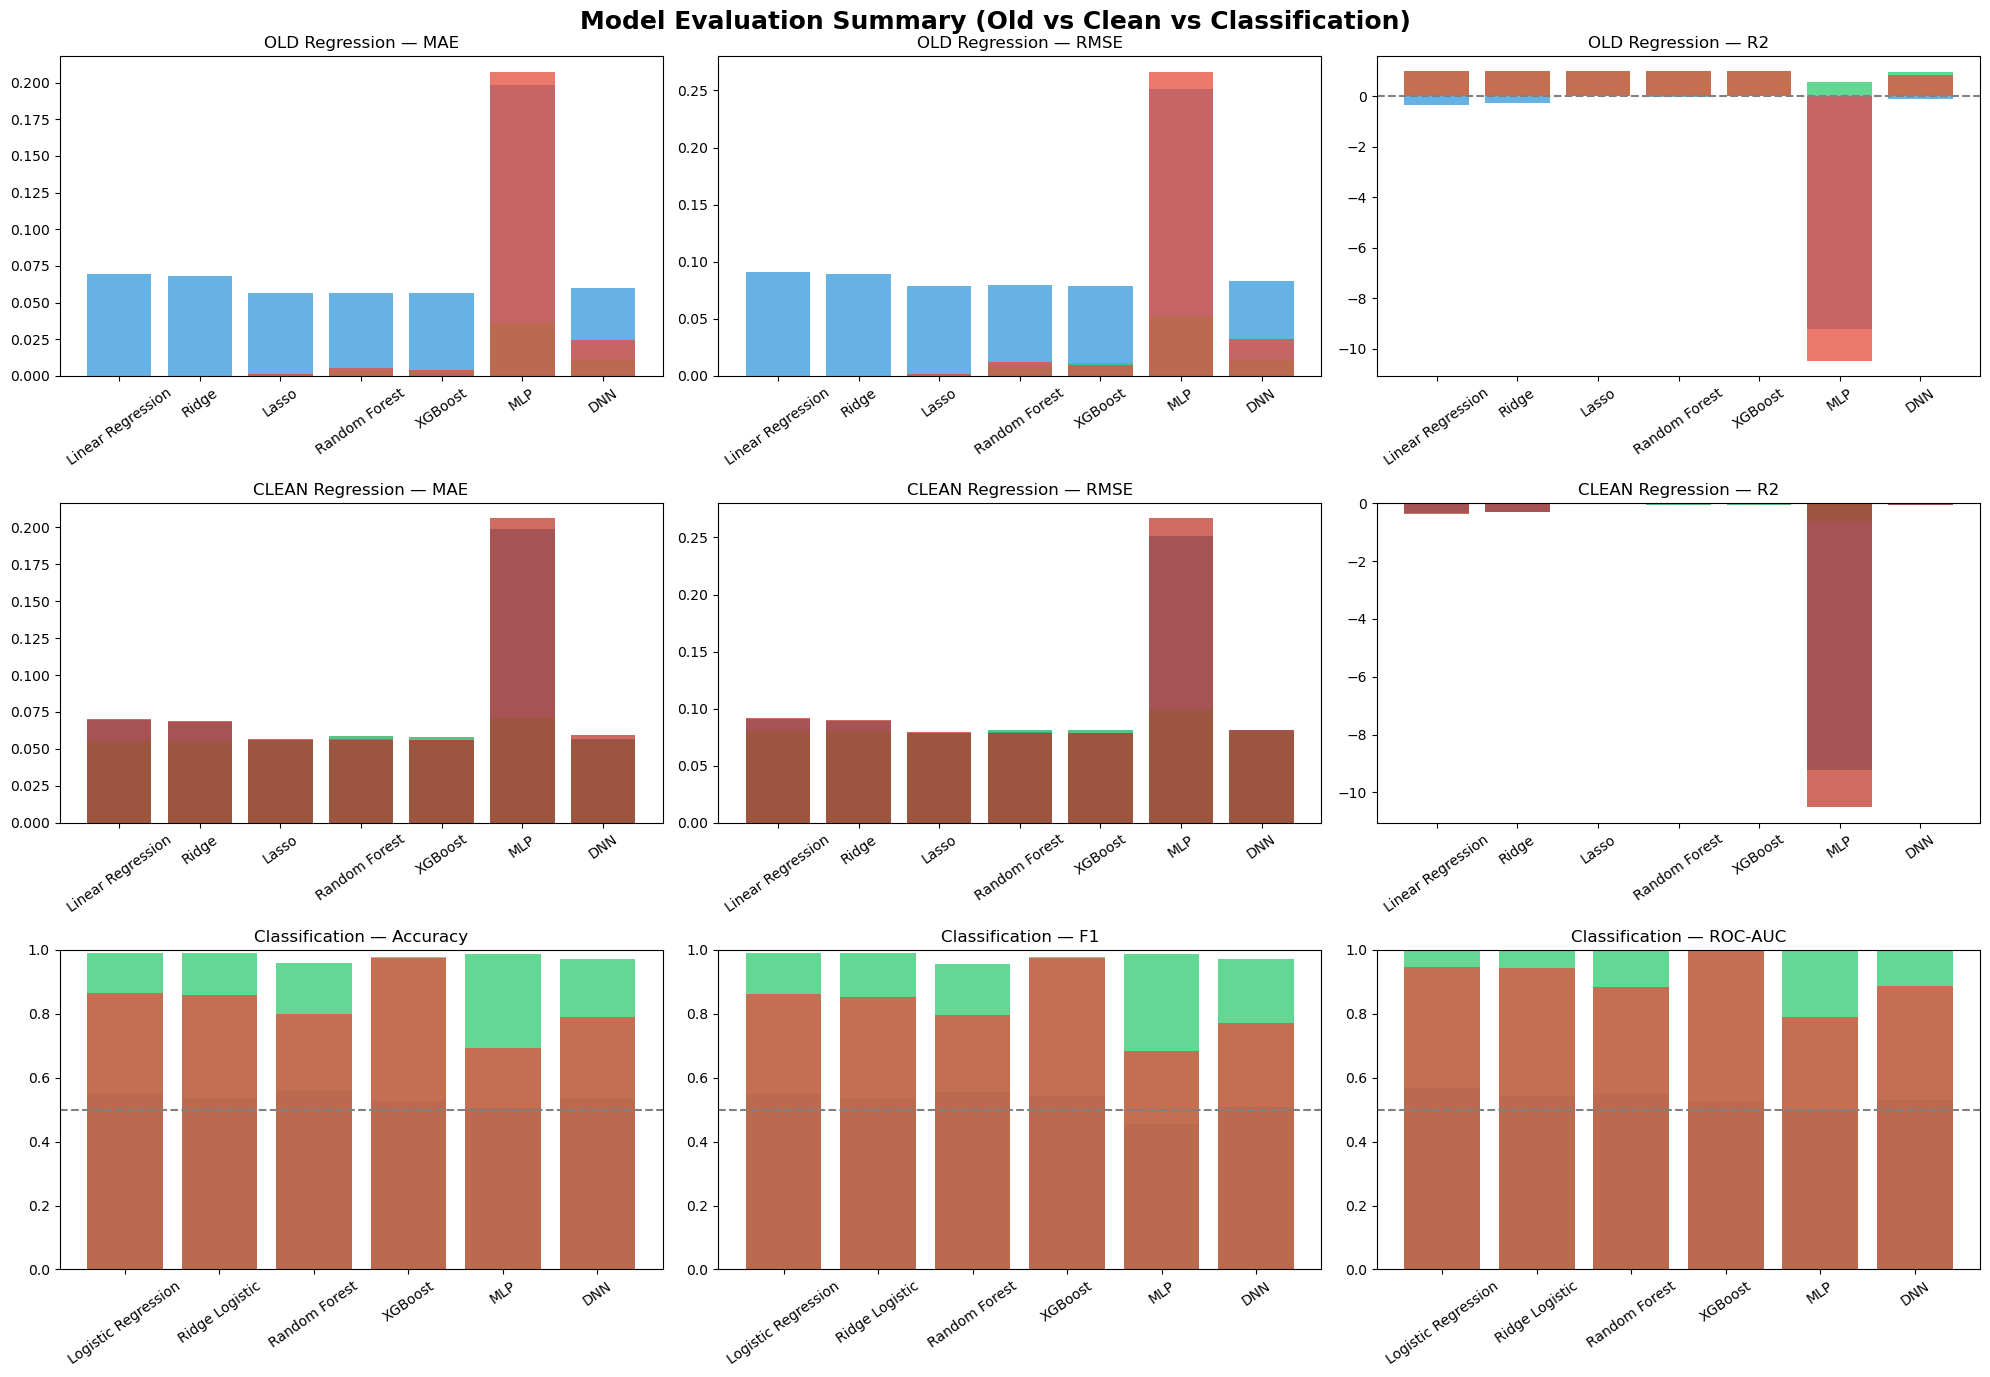

In [20]:
# ─────────────────────────────────────────────────────────────
# FULL MODEL COMPARISON (OLD REG + CLEAN REG + CLASSIFICATION)
# ─────────────────────────────────────────────────────────────

fig, axes = plt.subplots(3, 3, figsize=(20, 14))
fig.suptitle('Model Evaluation Summary (Old vs Clean vs Classification)', 
             fontsize=18, fontweight='bold')

FEATURE_SETS = ['Text-only', 'Finance-only', 'Fusion']
FEATURE_SETS_CLEAN = ['Text-only CLEAN', 'Finance-only CLEAN', 'Fusion CLEAN']

PALETTE = {
    'Text-only': '#3498db',
    'Finance-only': '#2ecc71',
    'Fusion': '#e74c3c',
    'Text-only CLEAN': '#2980b9',
    'Finance-only CLEAN': '#27ae60',
    'Fusion CLEAN': '#c0392b'
}

# ───────────────── OLD REGRESSION ───────────────────────────
for ax, metric in zip(axes[0], ['MAE', 'RMSE', 'R2']):
    for fs in FEATURE_SETS:
        subset = df_reg[df_reg['FeatureSet'] == fs]
        if subset.empty:
            continue
        ax.bar(subset['Model'], subset[metric],
               alpha=0.75,
               color=PALETTE[fs])
    ax.set_title(f'OLD Regression — {metric}', fontsize=12)
    ax.tick_params(axis='x', rotation=35)
    if metric == 'R2':
        ax.axhline(0, color='gray', linestyle='--')

# ───────────────── CLEAN REGRESSION ─────────────────────────
for ax, metric in zip(axes[1], ['MAE', 'RMSE', 'R2']):
    for fs in FEATURE_SETS_CLEAN:
        subset = df_reg_clean[df_reg_clean['FeatureSet'] == fs]
        if subset.empty:
            continue
        ax.bar(subset['Model'], subset[metric],
               alpha=0.75,
               color=PALETTE[fs])
    ax.set_title(f'CLEAN Regression — {metric}', fontsize=12)
    ax.tick_params(axis='x', rotation=35)
    if metric == 'R2':
        ax.axhline(0, color='gray', linestyle='--')

# ───────────────── CLASSIFICATION ───────────────────────────
for ax, metric in zip(axes[2], ['Accuracy', 'F1', 'ROC-AUC']):
    for fs in FEATURE_SETS:
        subset = df_cls[df_cls['FeatureSet'] == fs]
        if subset.empty:
            continue
        ax.bar(subset['Model'], subset[metric],
               alpha=0.75,
               color=PALETTE[fs])
    ax.set_title(f'Classification — {metric}', fontsize=12)
    ax.tick_params(axis='x', rotation=35)
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='gray', linestyle='--')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/model_comparison_full.png',
            dpi=150,
            bbox_inches='tight')

plt.show()

In [22]:
print('=' * 70)
print('🏆  BEST MODELS SUMMARY (OLD vs CLEAN vs CLASSIFICATION)')
print('=' * 70)

# ───────────────── OLD REGRESSION ─────────────────
print('\n📉 OLD Regression (↓ RMSE, ↑ R²)')
best_reg_old = df_reg.loc[df_reg.groupby('FeatureSet')['R2'].idxmax()]
print(best_reg_old[['FeatureSet','Model','MAE','RMSE','R2']]
      .sort_values('FeatureSet')
      .to_string(index=False))

# ───────────────── CLEAN REGRESSION ───────────────
print('\n🧪 CLEAN Regression (Real Prediction)')
best_reg_clean = df_reg_clean.loc[df_reg_clean.groupby('FeatureSet')['R2'].idxmax()]
print(best_reg_clean[['FeatureSet','Model','MAE','RMSE','R2']]
      .sort_values('FeatureSet')
      .to_string(index=False))

# ───────────────── CLASSIFICATION ─────────────────
print('\n🎯 Classification (↑ ROC-AUC)')
best_cls = df_cls.loc[df_cls.groupby('FeatureSet')['ROC-AUC'].idxmax()]
print(best_cls[['FeatureSet','Model','Accuracy','F1','ROC-AUC']]
      .sort_values('FeatureSet')
      .to_string(index=False))


# ───────────────── OUTPUT FILE CHECK ──────────────
print('\n📁 Output files status:')
files_to_check = [
    'events_raw.csv',
    'events_with_finance.csv',
    'final_dataset.csv',
    'regression_results.csv',
    'regression_results_clean.csv',
    'classification_results.csv',
    'car_distribution.png',
    'model_comparison.png',
    'model_comparison_full.png'
]

for fn in files_to_check:
    path = f'{OUTPUT_DIR}/{fn}'
    exists = '✅' if os.path.exists(path) else '❌'
    print(f'  {exists}  {path}')

🏆  BEST MODELS SUMMARY (OLD vs CLEAN vs CLASSIFICATION)

📉 OLD Regression (↓ RMSE, ↑ R²)
  FeatureSet             Model     MAE    RMSE      R2
Finance-only Linear Regression 0.00000 0.00000  1.0000
      Fusion Linear Regression 0.00000 0.00000  1.0000
   Text-only           XGBoost 0.05618 0.07883 -0.0059

🧪 CLEAN Regression (Real Prediction)
        FeatureSet   Model     MAE    RMSE      R2
Finance-only CLEAN   Lasso 0.05533 0.07884 -0.0063
      Fusion CLEAN XGBoost 0.05603 0.07863 -0.0009
   Text-only CLEAN XGBoost 0.05618 0.07883 -0.0059

🎯 Classification (↑ ROC-AUC)
  FeatureSet               Model  Accuracy     F1  ROC-AUC
Finance-only Logistic Regression    0.9900 0.9899   0.9998
      Fusion             XGBoost    0.9761 0.9757   0.9982
   Text-only Logistic Regression    0.5478 0.5487   0.5668

📁 Output files status:
  ✅  C:\applied time series\ats sem project\outputs/events_raw.csv
  ✅  C:\applied time series\ats sem project\outputs/events_with_finance.csv
  ✅  C:\applied 